In [1]:
import os; os.chdir('..')
import numpy as np
import torch
from torchvision import transforms
import apex
import csv
import dataset_word as data
import models_attn as models
import ast
from sklearn.model_selection import train_test_split
# from tqdm.notebook import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
#from config import config

class Config:
    # data
    cleaned_reports = "./xray-dataset/cleaned_reports.csv"
    image_dir = "./xray-dataset/images/images_normalized/"
    file_list = "./xray-dataset/indiana_projections.csv"
    pretrained_emb = True    
    emb_file = "./vectors/glove.6B.300d.txt"
    PAD_idx = 0
    UNK_idx = 1
    EOS_idx = 2
    SOS_idx = 3

    # model
    emb_dim = 300
    hidden_dim = 256
    num_layers = 3

    # training
    batch_size = 4
    learning_rate = 0.001
    
    # Others
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = Config()

### Data Loading

In [2]:
def parse_list(input_str):    
    return ast.literal_eval(input_str)

reports = {}

with open(config.cleaned_reports) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            uid, problems, findings, impression = row[1:]
            reports[str(uid)] = (parse_list(problems), findings, impression)

In [3]:
def create_report_splits(reports, seed=1337):
    uid_list = list(reports.keys())
    train_uids, valtest_uids = train_test_split(uid_list, test_size=0.2, random_state=seed)
    valid_uids, test_uids = train_test_split(valtest_uids, test_size=0.5, random_state=seed)
    
    train_reports = {}
    valid_reports = {}
    test_reports = {}
    splits = [train_uids, valid_uids, test_uids]
    output_reports = [train_reports, valid_reports, test_reports]
    
    for i in range(len(splits)):
        for uid in splits[i]:
            output_reports[i][str(uid)] = reports[str(uid)]
            
    return output_reports

train_reports, valid_reports, _ = create_report_splits(reports)

train_dataset = data.XRayDataset(
    reports=train_reports,
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]
))
train_dataloader = torch.utils.data.dataloader.DataLoader(train_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          drop_last=True,
                                                          batch_size=config.batch_size,
                                                          num_workers=config.batch_size)

valid_dataset = data.XRayDataset(
    reports=valid_reports,
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ]
))
valid_dataloader = torch.utils.data.dataloader.DataLoader(valid_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          drop_last=True,
                                                          batch_size=config.batch_size,
                                                          num_workers=config.batch_size)

### Build Model

In [4]:
memory_format = torch.channels_last
num_classes = len(train_dataset.classes)

encoder = models.EncoderCNN(config.emb_dim, num_classes).to(config.device, memory_format=memory_format)
decoder = models.AttnDecoderRNN(attention_dim=config.hidden_dim,
                                embed_dim=config.emb_dim,
                                decoder_dim=config.hidden_dim,
                                vocab_size=train_dataset.tokenizer.n_words,
                                encoder_dim=512,
                                device=config.device).to(config.device, memory_format=memory_format)

classes_loss = torch.nn.BCEWithLogitsLoss()
outputs_loss = torch.nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = apex.optimizers.FusedAdam(params, lr=config.learning_rate)

[encoder, decoder], optimizer = apex.amp.initialize([encoder, decoder], optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


### Train Model

In [5]:
def train_one_epoch(dataloader, batch_size, encoder, decoder, classes_loss, outputs_loss, optimizer, train=True):
    total_step = len(dataloader.dataset)//batch_size
    if train:
        encoder.train()
        decoder.train()
    else:
        encoder.eval()
        decoder.eval()
    running_c_loss = torch.Tensor([0.0])
    running_o_loss = torch.Tensor([0.0])
    with torch.set_grad_enabled(train):
        for i, (images, class_labels, captions, lengths) in enumerate(progress_bar(dataloader)):
            images = images.to(config.device, non_blocking=True).contiguous(memory_format=memory_format)
            captions = captions.to(config.device, non_blocking=True)
            class_labels = class_labels.to(config.device, non_blocking=True)
            encoder.zero_grad()
            decoder.zero_grad()
            logits, features = encoder(images)
            c_loss = classes_loss(logits, class_labels)
            
            scores, caps_sorted, decode_lengths, alphas = decoder(features, captions, lengths)
            scores = torch.nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True, enforce_sorted=False)[0]
            targets = captions[:, 1:]
            targets = torch.nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True, enforce_sorted=False)[0]
            
            o_loss = outputs_loss(scores, targets)
            if train:
                with apex.amp.scale_loss(c_loss, optimizer) as scaled_loss:
                    scaled_loss.backward(retain_graph=True)
                with apex.amp.scale_loss(o_loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                optimizer.step()
            running_c_loss += c_loss
            running_o_loss += o_loss
    c_loss = float(running_c_loss.item()/total_step)
    o_loss = float(running_o_loss.item()/total_step)
    return c_loss, o_loss

In [6]:
num_epochs = 3

print("Start training")

for epoch in range(num_epochs):
    print("\nEpoch", epoch+1, "/", num_epochs, ":\n")
    
    train_c_loss, train_o_loss = train_one_epoch(train_dataloader, config.batch_size, encoder, decoder, classes_loss, outputs_loss, optimizer, train=True)
    valid_c_loss, valid_o_loss = train_one_epoch(valid_dataloader, config.batch_size, encoder, decoder, classes_loss, outputs_loss, optimizer, train=False)

    print("train_loss - ", round(train_c_loss,3),round(train_o_loss,3), "- perplexity -", round(np.exp(train_o_loss),3), 
          "- valid_loss - ", round(valid_c_loss,3),round(valid_o_loss,3), "- perplexity -", round(np.exp(valid_o_loss),3))

Start training

Epoch 1 / 3 :



train_loss -  0.153 3.785 - perplexity - 44.025 - valid_loss -  0.163 6.814 - perplexity - 910.44

Epoch 2 / 3 :



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


train_loss -  0.15 3.282 - perplexity - 26.63 - valid_loss -  0.149 7.108 - perplexity - 1221.567

Epoch 3 / 3 :



train_loss -  0.149 3.117 - perplexity - 22.583 - valid_loss -  0.173 7.324 - perplexity - 1516.711


In [7]:
torch.save(encoder.state_dict(), 'save/encoder_word.pt')
torch.save(decoder.state_dict(), 'save/decoder_word.pt')
encoder.load_state_dict(torch.load('save/encoder_word.pt'))
decoder.load_state_dict(torch.load('save/decoder_word.pt'))

<All keys matched successfully>

### Inference

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

encoder.eval()
decoder.eval()

AttnDecoderRNN(
  (attention): Attention(
    (encoder_att): Linear(in_features=512, out_features=256, bias=True)
    (decoder_att): Linear(in_features=256, out_features=256, bias=True)
    (full_att): Linear(in_features=256, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(1973, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (decode_step): LSTMCell(812, 256)
  (init_h): Linear(in_features=512, out_features=256, bias=True)
  (init_c): Linear(in_features=512, out_features=256, bias=True)
  (f_beta): Linear(in_features=256, out_features=512, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=256, out_features=1973, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


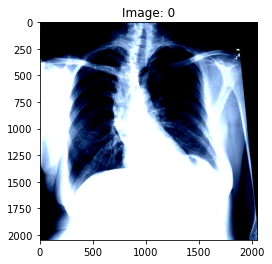

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos no acute changes from prior imaging . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



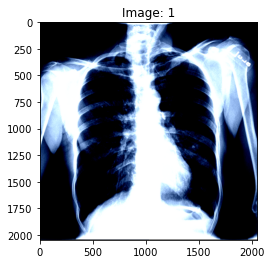

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos 1. no acute cardiopulmonary abnormality . 2. no suspicious masses or nodules . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



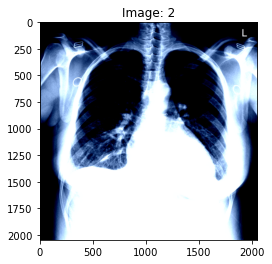

 Original: SOS sos borderline cardiac enlargement . vascular congestion without overt pulmonary edema . basilar atelectasis with xxxx posterior recess pleural effusions . overall , findings of mild volume overload . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


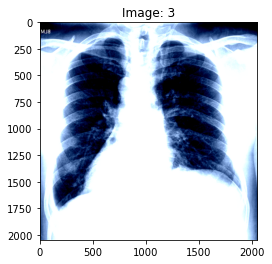

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos xxxx xxxx right pleural effusion . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



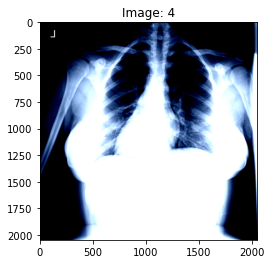

 Original: SOS sos no acute cardiopulmonary abnormality identified . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


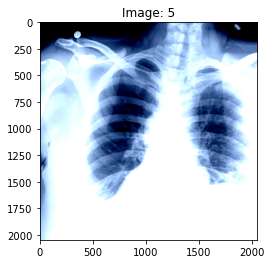

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos minimal atelectasis right base . no evidence of tuberculosis . heart size is normal . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



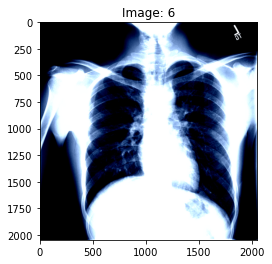

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos no acute cardiopulmonary disease . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



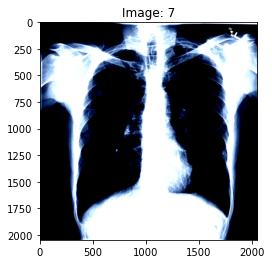

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos appearance suggests emphysema . apical capping , slightly greater at the left . recommend comparison with prior films or followup chest x-xxxx films to confirm stability and approximately 4 months in xxxx . critical result notification documented through primordial . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



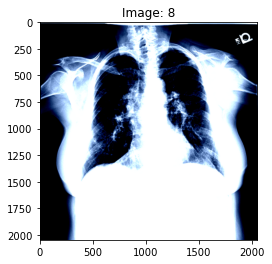

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: SOS sos 1. continued hilar fullness consistent with adenopathy and bilateral interstitial opacities . stable as compared to earlier study . the changes are compatible with known diagnosis of sarcoidosis . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



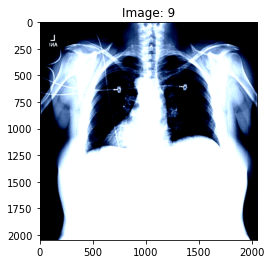

 Original: SOS sos negative for acute abnormality . eos EOS
Generated: sos no acute cardiopulmonary abnormality . eos EOS . eos EOS of the chest . eos EOS of the chest . eos EOS of the chest . eos EOS of the



In [9]:
for index in range(0, 10):
    image, _, impression = train_dataset.__getitem__(index)
    image_tensor = image.unsqueeze(0).to(config.device)
    logits, features = encoder(image_tensor)
    
    seed = ["SOS", ]
    seed = torch.from_numpy(train_dataset.tokenizer.encode(seed)).unsqueeze(0).cuda()
    
    predictions, seed, decode_lengths, alphas = decoder.sample(features, seed, [32, ])
    
    sampled_ids = list(predictions[0].cpu().numpy())

    plt.title("Image: "+str(index))
    plt_img = np.moveaxis(image.numpy(), 0, -1)
    plt.imshow(plt_img)
    plt.show()

    print(" Original:", train_dataset.tokenizer.decode(impression))
    print("Generated:", train_dataset.tokenizer.decode(sampled_ids))
    print("")